In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, LSTM
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading the CSV file
file_path = '/content/credit_scores.csv'
data = pd.read_csv(file_path)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        100000 non-null  int64  
 1   Customer_ID               100000 non-null  int64  
 2   Month                     100000 non-null  int64  
 3   Name                      100000 non-null  object 
 4   Age                       100000 non-null  float64
 5   SSN                       100000 non-null  float64
 6   Occupation                100000 non-null  object 
 7   Annual_Income             100000 non-null  float64
 8   Monthly_Inhand_Salary     100000 non-null  float64
 9   Num_Bank_Accounts         100000 non-null  float64
 10  Num_Credit_Card           100000 non-null  float64
 11  Interest_Rate             100000 non-null  float64
 12  Num_of_Loan               100000 non-null  float64
 13  Type_of_Loan              100000 non-null  ob

In [3]:
# - Numerical columns: mean
# - Categorical columns: mode (most frequent value)

# Dropping the 'Month' column first to prevent conflicts
data = data.drop(columns=['Month'])

# Identify the categorical and numerical columns
categorical_columns = data.select_dtypes(include=['object']).columns
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Re-aggregating the data
aggregated_data = data.groupby('Customer_ID').agg(
    {**{col: 'mean' for col in numerical_columns if col != 'Month' and col != 'Customer_ID'},
     **{col: lambda x: x.mode()[0] for col in categorical_columns}}).reset_index()

# Rounding off the floating-point values to the nearest integer
aggregated_data[numerical_columns] = aggregated_data[numerical_columns].round(0).astype(int)

aggregated_data.head()


,Customer_ID,ID,Age,SSN,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,...,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Name,Occupation,Type_of_Loan,Credit_Mix,Payment_of_Min_Amount,Payment_Behaviour,Credit_Score
0,1006,27754,38,354656948,16756,1331,9,6,22,2,...,27,45,315,Matthias Blamontb,Journalist,"Credit-Builder Loan, and Payday Loan",Standard,Yes,Low_spent_Small_value_payments,Poor
1,1007,53254,48,964812710,21213,1497,3,4,10,3,...,46,30,286,Soyoung Kimu,Manager,"Home Equity Loan, Mortgage Loan, and Student Loan",Standard,No,Low_spent_Small_value_payments,Standard
2,1008,56854,37,802194704,33540,2655,6,3,17,0,...,0,51,362,Koht,Developer,No Data,Standard,Yes,High_spent_Small_value_payments,Standard
3,1009,84334,22,891062189,80984,6693,6,3,15,4,...,188,101,523,Edd,Accountant,"Credit-Builder Loan, Student Loan, Not Specifi...",Standard,Yes,High_spent_Medium_value_payments,Standard
4,1011,39358,44,422130011,104143,8434,3,5,5,3,...,258,102,446,Terry Wadeu,Writer,"Personal Loan, Auto Loan, and Auto Loan",Standard,Yes,Low_spent_Medium_value_payments,Standard


In [4]:
# Saving the cleaned DataFrame to a new CSV file
aggregated_data.to_csv('cleaned_credit_scores_dataset.csv', index=False)

In [5]:

# List of columns to drop
columns_to_drop = [
    'Customer_ID',
    'ID',
    'SSN',
    'Name',
]

# Dropping the unnecessary columns
df_cleaned = aggregated_data.drop(columns=columns_to_drop)

df_cleaned.head()



,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,...,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance,Occupation,Type_of_Loan,Credit_Mix,Payment_of_Min_Amount,Payment_Behaviour,Credit_Score
0,38,16756,1331,9,6,22,2,48,12,11,...,186,27,45,315,Journalist,"Credit-Builder Loan, and Payday Loan",Standard,Yes,Low_spent_Small_value_payments,Poor
1,48,21213,1497,3,4,10,3,19,19,6,...,350,46,30,286,Manager,"Home Equity Loan, Mortgage Loan, and Student Loan",Standard,No,Low_spent_Small_value_payments,Standard
2,37,33540,2655,6,3,17,0,26,11,14,...,296,0,51,362,Developer,No Data,Standard,Yes,High_spent_Small_value_payments,Standard
3,22,80984,6693,6,3,15,4,19,18,17,...,334,188,101,523,Accountant,"Credit-Builder Loan, Student Loan, Not Specifi...",Standard,Yes,High_spent_Medium_value_payments,Standard
4,44,104143,8434,3,5,5,3,19,15,16,...,182,258,102,446,Writer,"Personal Loan, Auto Loan, and Auto Loan",Standard,Yes,Low_spent_Medium_value_payments,Standard


In [6]:
numerical_columns = df_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = df_cleaned.select_dtypes(include=['object']).columns.tolist()

# Encoding categorical variables using LabelEncoder
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(aggregated_data[col])
    label_encoders[col] = le

# Scaling numerical features using StandardScaler
scaler = StandardScaler()
df_cleaned[numerical_columns] = scaler.fit_transform(df_cleaned[numerical_columns])


In [8]:
X = df_cleaned.drop(columns=['Credit_Score'])
y = df_cleaned['Credit_Score']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [9]:
def generate_classification_report_confusion_matrix(y_test, y_pred):
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Classification report
    print("Classification Report:\n", report)

    # Confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

def evaluate_model(model, X_train, X_test, y_train, y_test):
    print(model)

    # Fit the model and make predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    generate_classification_report_confusion_matrix(y_test,y_pred)
    # Return performance metrics
    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted'),
        'ROC-AUC': roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr')
    }

def evaluate_DL_model(model, X_train, X_test, y_train, y_test):
    print(model)

    # Fit the model
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

    y_pred_probs = model.predict(X_test)

    # Convert probabilities to class labels
    y_pred = np.argmax(y_pred_probs, axis=1)

    generate_classification_report_confusion_matrix(y_test,y_pred)

    # Return performance metrics
    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred, average='weighted'),
        'ROC-AUC': roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
    }

LogisticRegression()
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.64      0.60       366
           1       0.72      0.56      0.63       628
           2       0.66      0.72      0.69       881

    accuracy                           0.65      1875
   macro avg       0.65      0.64      0.64      1875
weighted avg       0.66      0.65      0.65      1875



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


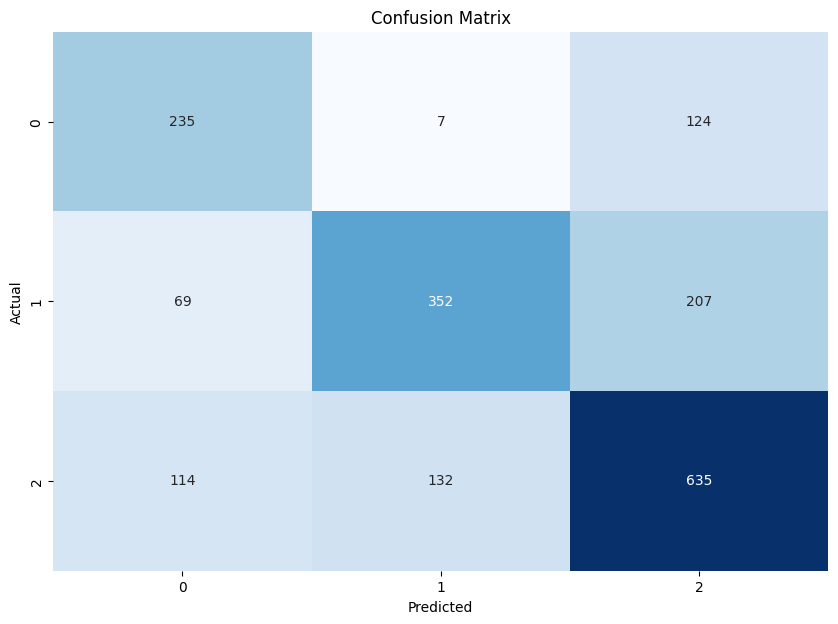

RandomForestClassifier()
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.78      0.70       366
           1       0.78      0.74      0.76       628
           2       0.79      0.74      0.77       881

    accuracy                           0.75      1875
   macro avg       0.73      0.75      0.74      1875
weighted avg       0.76      0.75      0.75      1875



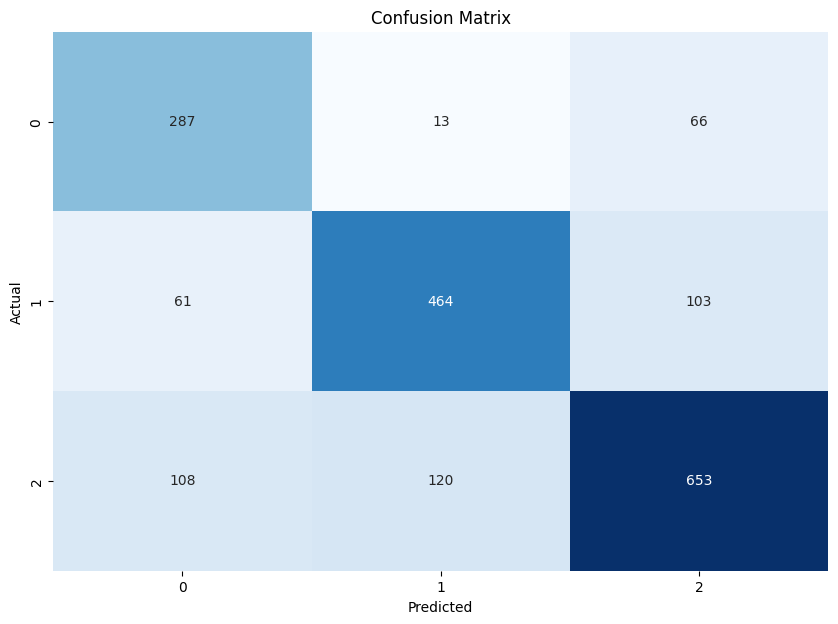

SVC(probability=True)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       366
           1       0.00      0.00      0.00       628
           2       0.47      1.00      0.64       881

    accuracy                           0.47      1875
   macro avg       0.16      0.33      0.21      1875
weighted avg       0.22      0.47      0.30      1875



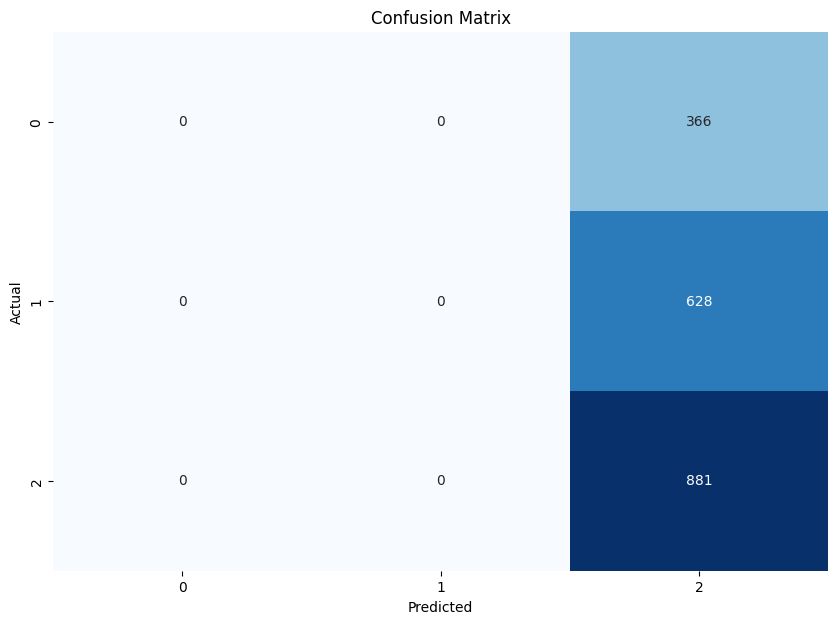

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.72      0.68       366
           1       0.75      0.72      0.74       628
           2       0.76      0.75      0.75       881



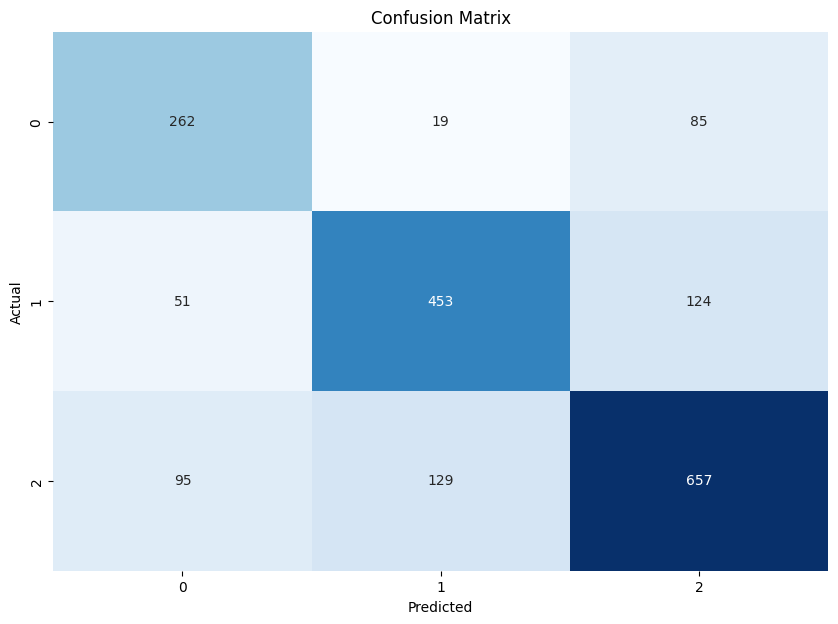

In [10]:
# Machine Learning Models
ml_models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(probability=True),
    'XGBoost': xgb.XGBClassifier()
}

ml_results = {name: evaluate_model(model, X_train, X_test, y_train, y_test) for name, model in ml_models.items()}


MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300)
Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.87      0.57       366
           1       0.71      0.69      0.70       628
           2       0.76      0.44      0.56       881

    accuracy                           0.61      1875
   macro avg       0.63      0.67      0.61      1875
weighted avg       0.68      0.61      0.61      1875



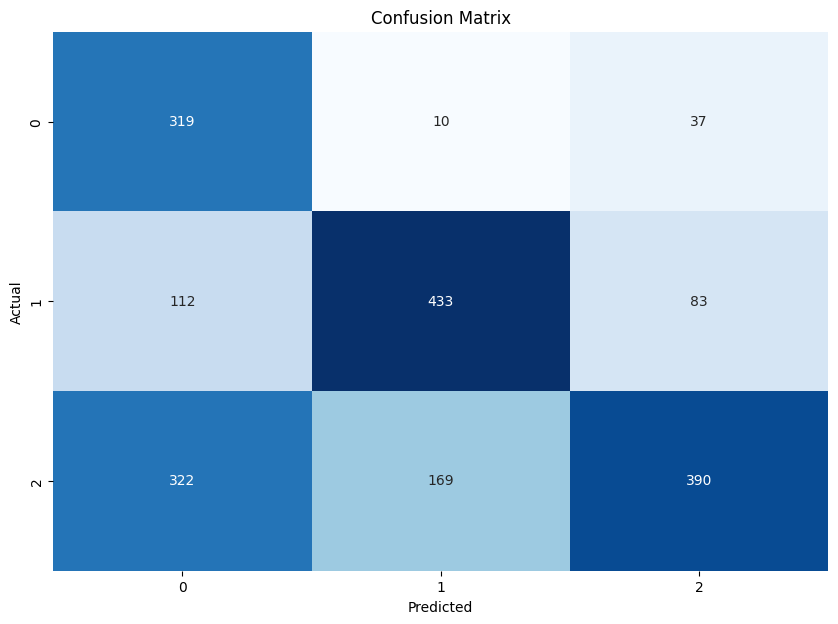

In [11]:
# Deep Learning Models

# 1. Simple Neural Network (MLP)
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300)
mlp_results = evaluate_model(mlp, X_train, X_test, y_train, y_test)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<Sequential name=sequential, built=True>
Epoch 1/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.4146 - loss: 19.1495 - val_accuracy: 0.6181 - val_loss: 1.4691
Epoch 2/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.5083 - loss: 2.4499 - val_accuracy: 0.5456 - val_loss: 1.1075
Epoch 3/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4987 - loss: 2.3993 - val_accuracy: 0.4722 - val_loss: 1.8829
Epoch 4/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5323 - loss: 1.9515 - val_accuracy: 0.6811 - val_loss: 0.8456
Epoch 5/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5850 - loss: 1.6027 - val_accuracy: 0.5475 - val_loss: 1.2849
Epoch 6/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5623 - loss: 1.8035 - val_accuracy: 0.5230 - val_loss: 3.9821
Epoch 7/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5700 - loss: 1.7022 - val_accuracy: 0.5569 - val_loss: 2.5114
Epoch 8/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accur

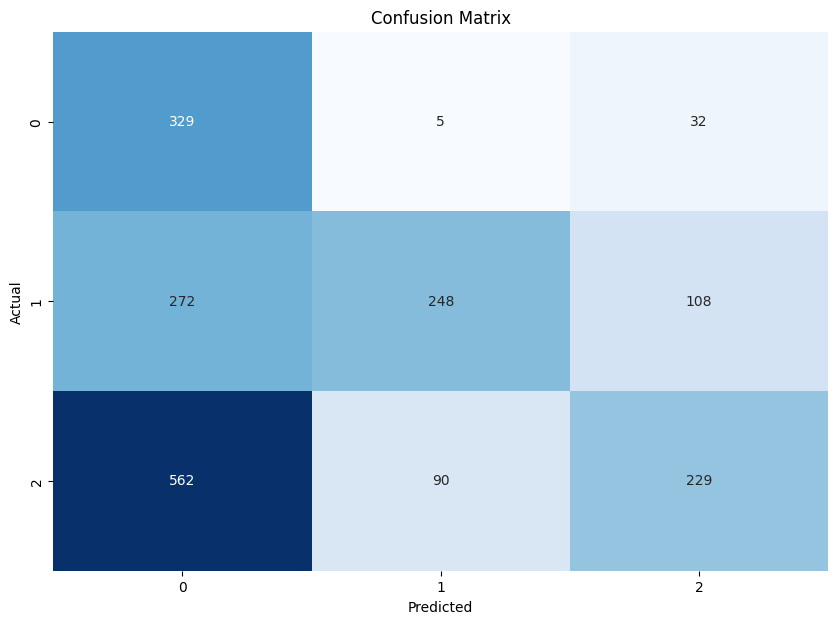

In [12]:
# 2. Convolutional Neural Network (CNN)
cnn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # 3 classes for Credit_Score
])
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_results = evaluate_DL_model(cnn_model, X_train, X_test, y_train, y_test)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


<Sequential name=sequential_1, built=True>
Epoch 1/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5557 - loss: 0.9331 - val_accuracy: 0.6820 - val_loss: 0.7463
Epoch 2/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6882 - loss: 0.7415 - val_accuracy: 0.6802 - val_loss: 0.7247
Epoch 3/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6944 - loss: 0.7161 - val_accuracy: 0.7046 - val_loss: 0.7010
Epoch 4/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7105 - loss: 0.7045 - val_accuracy: 0.7084 - val_loss: 0.6944
Epoch 5/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7135 - loss: 0.6928 - val_accuracy: 0.6952 - val_loss: 0.7006
Epoch 6/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7011 - loss: 0.6939 - val_accuracy: 0.7112 - val_loss: 0.6912
Epoch 7/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7103 - loss: 0.6927 - val_accuracy: 0.7046 - val_loss: 0.6837
Epoch 8/20
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accurac

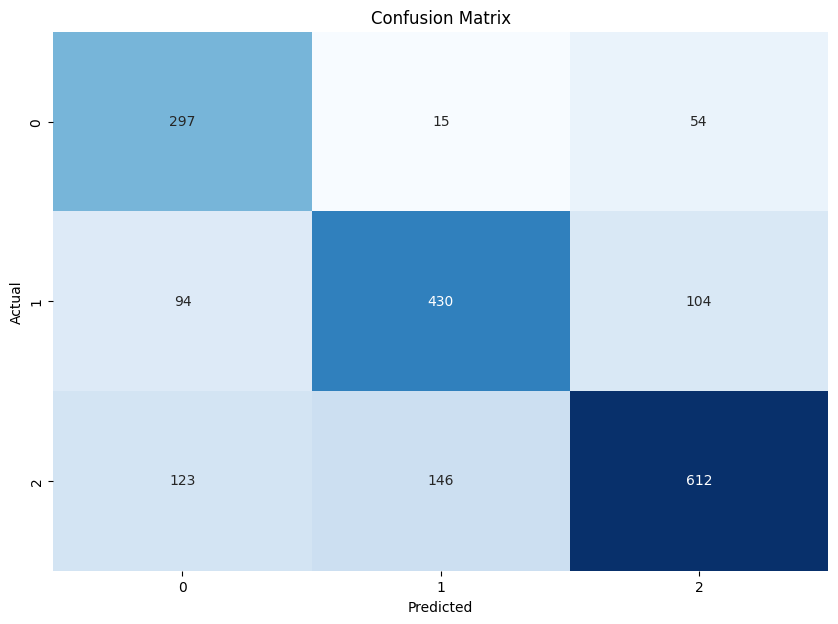

In [13]:
# 3. Recurrent Neural Network (LSTM)
X_train_lstm = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
lstm_model = Sequential([
    LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(25, activation='relu'),
    Dense(3, activation='softmax')
])
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_results = evaluate_DL_model(lstm_model, X_train_lstm, X_test_lstm, y_train, y_test)

In [14]:
# Combine Results for Comparison
comparison_results = {
    'Logistic Regression': ml_results['Logistic Regression'],
    'Random Forest': ml_results['Random Forest'],
    'SVM': ml_results['SVM'],
    'XGBoost': ml_results['XGBoost'],
    'MLP': mlp_results,
    'CNN': cnn_results,
    'LSTM': lstm_results
}

# Converting results to DataFrame for easier comparison
comparison_df = pd.DataFrame(comparison_results).T
print(comparison_df)


                     Accuracy  Precision    Recall  F1-Score   ROC-AUC
Logistic Regression  0.651733   0.658724  0.651733  0.650819  0.815283
Random Forest        0.748800   0.756437  0.748800  0.750369  0.883557
SVM                  0.469867   0.220775  0.469867  0.300401  0.787420
XGBoost              0.731733   0.734272  0.731733  0.732467  0.876298
MLP                  0.609067   0.678975  0.609067  0.608683  0.812754
CNN                  0.429867   0.588985  0.429867  0.427251  0.731376
LSTM                 0.714133   0.729934  0.714133  0.716399  0.854286


In [15]:
# Identify the best model based on Accuracy, F1-Score and ROC-AUC
best_model = comparison_df[['Accuracy', 'F1-Score', 'ROC-AUC']].idxmax()
print(f"Best model based on Accuracy: {best_model['Accuracy']}")
print(f"Best model based on F1-Score: {best_model['F1-Score']}")
print(f"Best model based on ROC-AUC: {best_model['ROC-AUC']}")

Best model based on Accuracy: Random Forest
Best model based on F1-Score: Random Forest
Best model based on ROC-AUC: Random Forest
